<a href="https://colab.research.google.com/github/smusman/Image-Classification-using-CNN/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <center>Assignment 2<center/>
### <center>Image Classification Using CNN and Transfer Learning<center/>

### Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/') 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Importing packages

In [2]:
from keras.layers import Input, Lambda, Dense, Flatten
from sklearn.datasets import load_files 
from keras.utils import np_utils
import numpy as np
import os
import zipfile
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.models import Model
from keras.preprocessing import image
import sklearn.metrics as metrics
import matplotlib.cm as cm
import seaborn as sns
from IPython.display import Image, display
%matplotlib inline

### Loading data

In [3]:
local_zip='/content/drive/MyDrive/Copy of chest_xray.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/chest_xray')
zip_ref.close()

In [4]:
#Defining the directories

train_path = '/tmp/chest_xray/chest_xray/train'
test_path = '/tmp/chest_xray/chest_xray/test'

train_normal_dir=os.path.join('/tmp/chest_xray/chest_xray/train/NORMAL')
train_PNEUMONIA_dir=os.path.join('/tmp/chest_xray/chest_xray/train/PNEUMONIA')
test_normal_dir=os.path.join('/tmp/chest_xray/chest_xray/test/NORMAL')
test_PNEUMONIA_dir=os.path.join('/tmp/chest_xray/chest_xray/test/PNEUMONIA')

In [5]:
#Total Number
print('Total Training Normal Xrays: ',len(os.listdir(train_normal_dir)))
print('Total Training PNEUMONIA Xrays: ',len(os.listdir(train_PNEUMONIA_dir)))
print('Total Test Normal Xrays: ',len(os.listdir(test_normal_dir)))
print('Total Test PNEUMONIA Xrays: ',len(os.listdir(test_PNEUMONIA_dir)))

Total Training Normal Xrays:  1349
Total Training PNEUMONIA Xrays:  3884
Total Test Normal Xrays:  234
Total Test PNEUMONIA Xrays:  390


### Show some images in the dataset

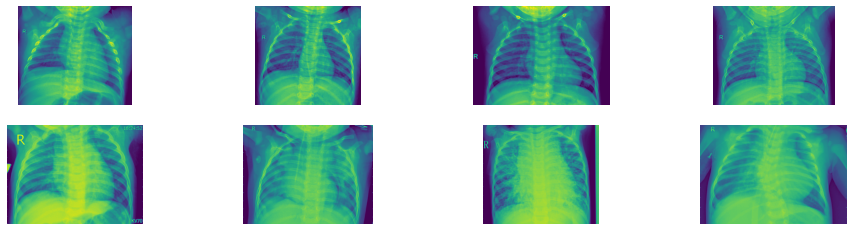

In [6]:
nrows=2
ncols=4

pic_index=0

fig=plt.gcf()
fig.set_size_inches(ncols*4,nrows*2)

pic_index+=4

next_normal_pix = [os.path.join(train_normal_dir,fname) for fname in os.listdir(train_normal_dir)[pic_index-4:pic_index]]
next_pne_pix = [os.path.join(train_PNEUMONIA_dir,fname) for fname in os.listdir(train_PNEUMONIA_dir)[pic_index-4:pic_index]]

for i, img_path in enumerate(next_normal_pix+next_pne_pix):
  sp=plt.subplot(nrows,ncols,i+1)
  sp.axis('Off')
  img=mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

### Data Augmentation using ImageDataGenerator 

In [7]:
train_datagen = ImageDataGenerator(
        rotation_range=40,                  #range within which to randomly rotate pictures
        width_shift_range=0.2,              #randomly translate pictures horizontally
        height_shift_range=0.2,             #randomly translate pictures vertically
        shear_range=0.2,                    #applying shear transformation
        zoom_range=0.2,                     #randomly zoom
        horizontal_flip=True,               #flip images horizontally
        fill_mode='nearest')

train_generator=train_datagen.flow_from_directory(
      '/tmp/chest_xray/chest_xray/train/',
      target_size=(224,224),
      batch_size=32,
      class_mode='categorical'
)

test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=train_datagen.flow_from_directory(
      '/tmp/chest_xray/chest_xray/test/',
      target_size=(224,224),
      batch_size=32,
      class_mode='categorical'
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Loading VGG16 

In [8]:
IMAGE_SIZE = [224, 224]
transfer_model = VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [9]:
#do not use existing weights
for layer in transfer_model.layers:
    layer.trainable = False

In [10]:
flatten = Flatten()(transfer_model.output)

# Dense layer.
prediction_layers = Dense(2, activation = 'softmax')(flatten)

model = Model(inputs=transfer_model.input, outputs=prediction_layers)

# Print the model summary.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Compile VGG16 Model

In [11]:
opt = keras.optimizers.Adam(learning_rate = 0.001)

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt,
    metrics = [ 'accuracy' ]
)

### Train VGG16 Model

In [12]:
history = model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 10,
    steps_per_epoch = len(train_generator),
    validation_steps = len(test_generator),
    batch_size = 32
)

Epoch 1/10
164/164 [==============================] - 154s 865ms/step - loss: 3.2117 - accuracy: 0.8876 - val_loss: 5.9059 - val_accuracy: 0.8333
Epoch 2/10
164/164 [==============================] - 137s 833ms/step - loss: 2.3969 - accuracy: 0.9274 - val_loss: 9.9025 - val_accuracy: 0.8093
Epoch 3/10
164/164 [==============================] - 136s 828ms/step - loss: 2.6980 - accuracy: 0.9320 - val_loss: 6.7532 - val_accuracy: 0.8526
Epoch 4/10
164/164 [==============================] - 135s 825ms/step - loss: 2.2188 - accuracy: 0.9429 - val_loss: 9.7677 - val_accuracy: 0.8301
Epoch 5/10
164/164 [==============================] - 136s 827ms/step - loss: 2.3849 - accuracy: 0.9440 - val_loss: 15.5399 - val_accuracy: 0.7917
Epoch 6/10
164/164 [==============================] - 132s 803ms/step - loss: 2.4170 - accuracy: 0.9430 - val_loss: 13.8070 - val_accuracy: 0.8045
Epoch 7/10
164/164 [==============================] - 134s 816ms/step - loss: 2.5986 - accuracy: 0.9453 - val_loss: 15.731

### Learning Curves for VGG16

(0.0, 18.001973807811737)

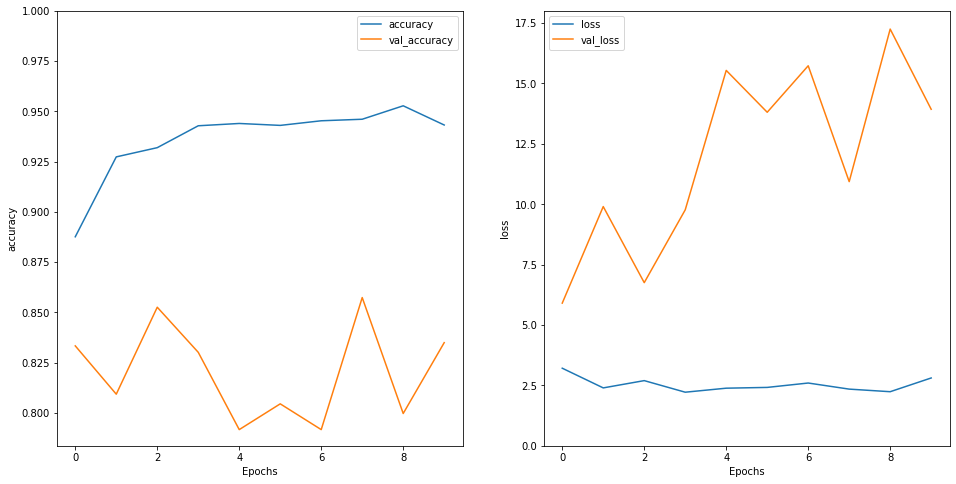

In [13]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

### Qualitaive Results VGG16

In [14]:
def model_predict(img):
    arr_img = image.img_to_array(img)
    arr_img = np.expand_dims(arr_img, axis = 0)

    # Preprocess the input using VGG-16's preprocess_input() method.
    arr_img_processed = preprocess_input(arr_img)
    
    # Perform prediction.
    result = model.predict(arr_img_processed)
    
    if(result[0][0] < result[0][1]):
        result_str = "-VE (Negative)"
    else:
        result_str = "+VE (Positive)"
    
    plt.figure()
    plt.imshow(img)
    plt.title('Predicted PNEUMONIA Status: ' + result_str)

#### PNEUMONIA_image

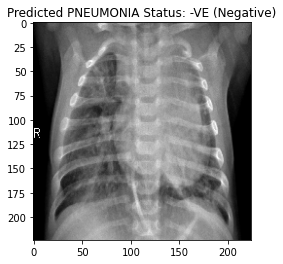

In [15]:
PNEUMONIA_image = image.load_img(test_path + '/PNEUMONIA/person100_bacteria_475.jpeg', target_size = (224, 224))
model_predict(PNEUMONIA_image)

#### Normal_image

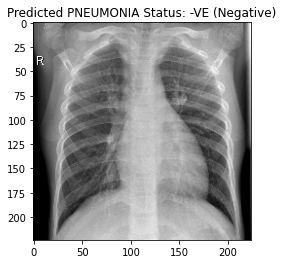

In [16]:
normal_image = image.load_img(test_path + '/NORMAL/NORMAL2-IM-0381-0001.jpeg', target_size = (224, 224))
model_predict(normal_image)

### Quantitative Results VGG16 (Loss, Accuracy and Confusion Matrix)

In [17]:
result=model.evaluate(test_generator)
print('Loss:',result[0])
print('Accuracy:',result[1])

20/20 [==============================] - 14s 680ms/step - loss: 13.6216 - accuracy: 0.8285
Loss: 13.621588706970215
Accuracy: 0.8285256624221802


### (Grad-CAM) Visualization


Prediction Results:
PNEUMONIA (+VE): 1.1223322e-17
Normal (-VE): 1.0


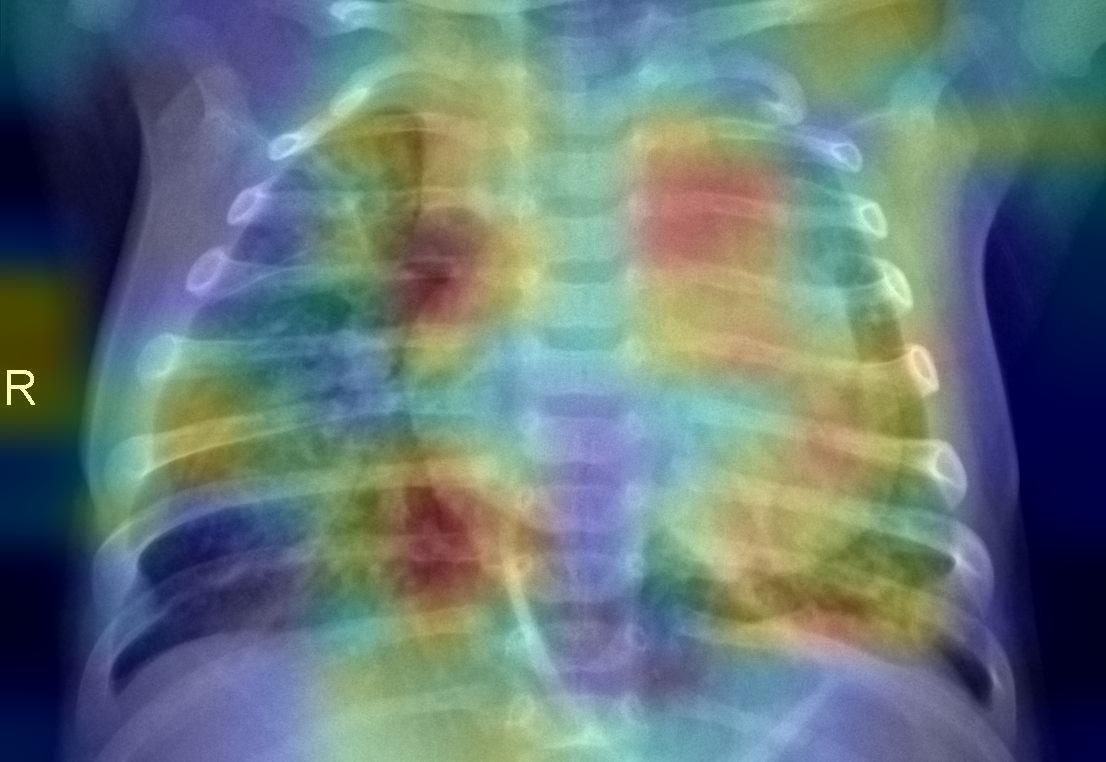

In [22]:
# Function to fetch an image in the form of an array.
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size = size)
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    return img_arr

# Function to generate the Grad-CAM heatmap from https://keras.io/examples/vision/grad_cam/.
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_size = (224, 224)
last_conv_layer_name = "block5_conv3"
img_path = test_path + '/PNEUMONIA/person100_bacteria_475.jpeg'

img_arr = preprocess_input(get_img_array(img_path, size=img_size))

# Remove activation for the outermost layer.
model.layers[-1].activation = None

pred_res = model.predict(img_arr)

print("Prediction Results:")
print("PNEUMONIA (+VE):", pred_res[0][0])
print("Normal (-VE):", pred_res[0][1])

# Generate Grad-CAM heatmap.
heatmap = make_gradcam_heatmap(img_arr, model, last_conv_layer_name)

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

### Loading Inception_v3 

In [75]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [76]:
IMAGE_SIZE = [224, 224]
transfer_model = InceptionV3(input_shape=IMAGE_SIZE + [3], include_top=False, weights="imagenet")

87924736/87910968 [==============================] - 2s 0us/step


In [77]:
#do not use existing weights
for layer in transfer_model.layers:
    layer.trainable = False

In [81]:
flatten = Flatten()(transfer_model.output)

# Dense layer.
prediction_layers = Dense(2, activation = 'softmax')(flatten)

model2 = Model(inputs=transfer_model.input, outputs=prediction_layers)

# Print the model summary.
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

### Compile Inception_v3 Model

In [82]:
opt = keras.optimizers.Adam(learning_rate = 0.001)

model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = opt,
    metrics = [ 'accuracy' ]
)

### Train Inception_v3 Model

In [83]:
history = model2.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 10,
    steps_per_epoch = len(train_generator),
    validation_steps = len(test_generator),
    batch_size = 32
)

Epoch 1/10
164/164 [==============================] - 141s 819ms/step - loss: 28.8244 - accuracy: 0.8121 - val_loss: 38.4528 - val_accuracy: 0.8221
Epoch 2/10
164/164 [==============================] - 132s 801ms/step - loss: 19.3472 - accuracy: 0.8580 - val_loss: 19.0672 - val_accuracy: 0.8173
Epoch 3/10
164/164 [==============================] - 131s 802ms/step - loss: 16.6302 - accuracy: 0.8708 - val_loss: 21.2445 - val_accuracy: 0.8013
Epoch 4/10
164/164 [==============================] - 128s 778ms/step - loss: 13.9223 - accuracy: 0.8838 - val_loss: 20.8549 - val_accuracy: 0.8333
Epoch 5/10
164/164 [==============================] - 129s 787ms/step - loss: 20.4996 - accuracy: 0.8664 - val_loss: 49.4162 - val_accuracy: 0.7772
Epoch 6/10
164/164 [==============================] - 128s 783ms/step - loss: 20.9017 - accuracy: 0.8708 - val_loss: 39.2277 - val_accuracy: 0.7885
Epoch 7/10
164/164 [==============================] - 129s 784ms/step - loss: 17.4218 - accuracy: 0.8847 - val_l

### Learning Curves for Inception_v3

(0.0, 51.251733493804934)

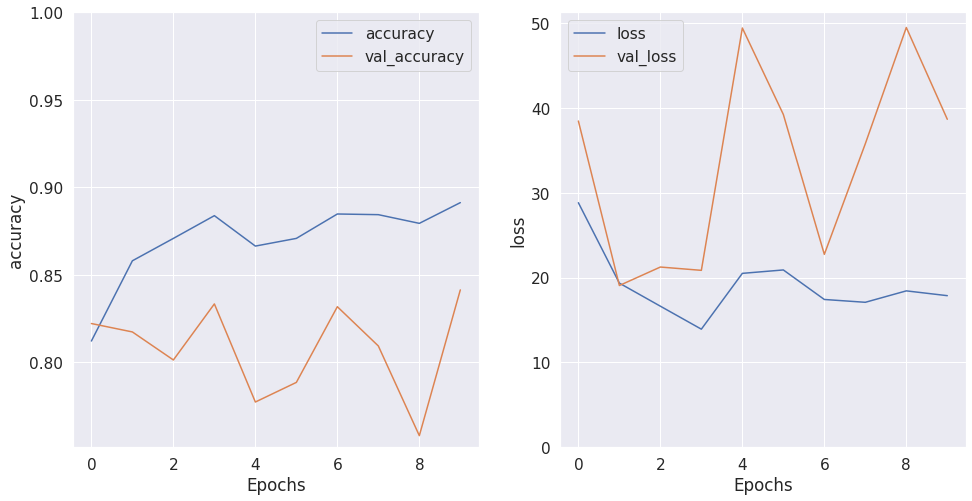

In [84]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

### Qualitaive Results Inception_v3

In [85]:
def model_predict(img):
    arr_img = image.img_to_array(img)
    arr_img = np.expand_dims(arr_img, axis = 0)

    # Preprocess the input using VGG-16's preprocess_input() method.
    arr_img_processed = preprocess_input(arr_img)
    
    # Perform prediction.
    result = model2.predict(arr_img_processed)
    
    if(result[0][0] < result[0][1]):
        result_str = "-VE (Negative)"
    else:
        result_str = "+VE (Positive)"
    
    plt.figure()
    plt.imshow(img)
    plt.title('Predicted PNEUMONIA Status: ' + result_str)

#### PNEUMONIA_image

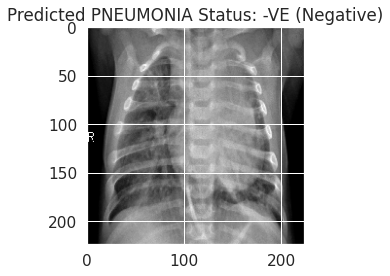

In [86]:
PNEUMONIA_image = image.load_img(test_path + '/PNEUMONIA/person100_bacteria_475.jpeg', target_size = (224, 224))
model_predict(PNEUMONIA_image)

#### Normal_image

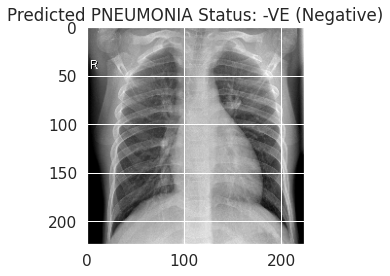

In [87]:
normal_image = image.load_img(test_path + '/NORMAL/NORMAL2-IM-0381-0001.jpeg', target_size = (224, 224))
model_predict(normal_image)

### Quantitative Results Inception_v3 (Loss and Accuracy)

In [88]:
result=model2.evaluate(test_generator)
print('Loss:',result[0])
print('Accuracy:',result[1])

20/20 [==============================] - 13s 664ms/step - loss: 32.8938 - accuracy: 0.8574
Loss: 32.89384460449219
Accuracy: 0.8573718070983887


### (Grad-CAM) Visualization


Prediction Results:
PNEUMONIA (+VE): 2.7006814e-14
Normal (-VE): 1.0


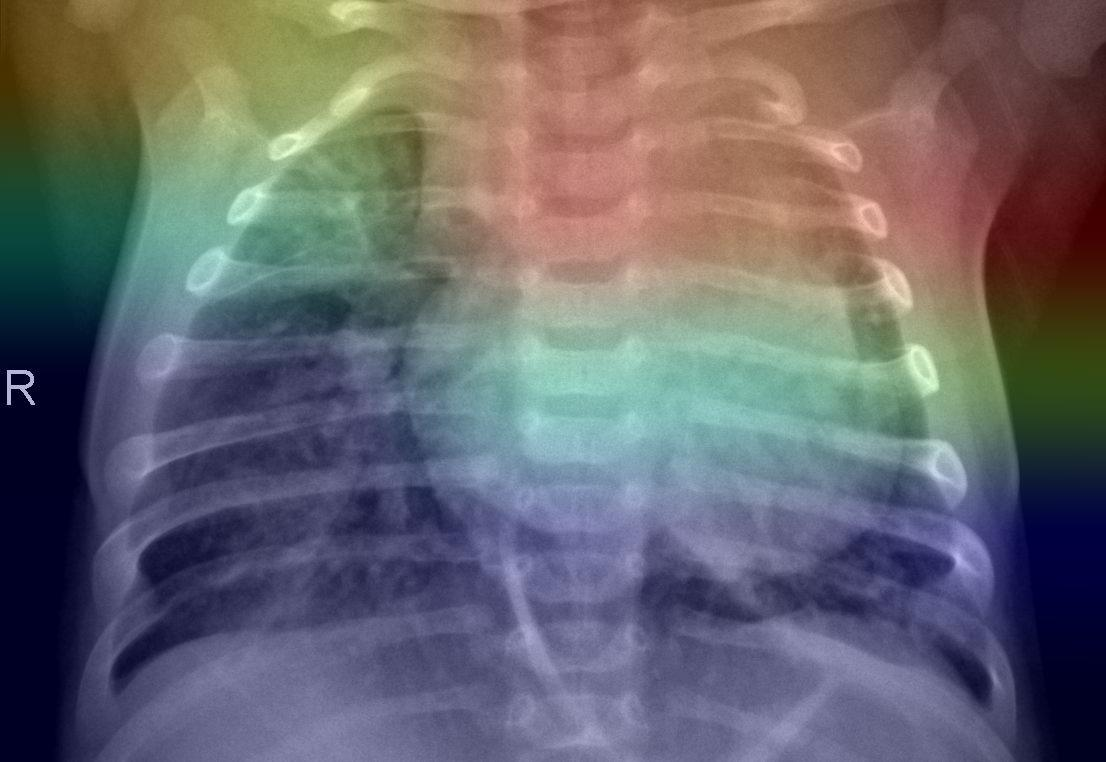

In [90]:
# Function to fetch an image in the form of an array.
def get_img_array(img_path, size):
    img = image.load_img(img_path, target_size = size)
    img_arr = image.img_to_array(img)
    img_arr = np.expand_dims(img_arr, axis=0)
    return img_arr

# Function to generate the Grad-CAM heatmap from https://keras.io/examples/vision/grad_cam/.
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions.
    grad_model = tf.keras.models.Model(
        [model2.inputs], [model2.get_layer(last_conv_layer_name).output, model2.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1.
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_size = (224, 224)
last_conv_layer_name = "conv2d_93"
img_path = test_path + '/PNEUMONIA/person100_bacteria_475.jpeg'

img_arr = preprocess_input(get_img_array(img_path, size=img_size))

# Remove activation for the outermost layer.
model2.layers[-1].activation = None

pred_res = model2.predict(img_arr)

print("Prediction Results:")
print("PNEUMONIA (+VE):", pred_res[0][0])
print("Normal (-VE):", pred_res[0][1])

# Generate Grad-CAM heatmap.
heatmap = make_gradcam_heatmap(img_arr, model2, last_conv_layer_name)

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)